In [2]:
import numpy as np

These were experiments to find examples of computing XOR with a (limited) ENCODER-DECODER model. After doing some theory, here are thoughts so far:
 - Single layer encoder-decoder: With _unbiased_ encoder FFNN, no decoder self-attention, no Layer-Norm, and no decoder FFNN, this is IMPOSSIBLE. Thoughts: decoder FFNN, decoder self-attention will probably not affect this result.
 - Next thing is to check is with bias. I bet that helps a lot
 - A two layer encoder can do this arbitrarily well (https://arxiv.org/pdf/2202.12172).

In [3]:
XOR_INPUTS = [np.array([[1, 0], [1, 0]]), np.array([[0, 1], [1, 0]]), np.array([[1, 0], [0, 1]]), np.array([[0, 1], [0, 1]]), ]
INPUTS = [(0, 0), (1, 0), (0, 1), (1, 1)]

EXPERIMENT 1: Single layer, encoder-decoder, but no FFNN at the end of encoder.
Output of encoder is
$$
H = \sigma(X W_Q W_K^T X^T) X W_V
$$

Output of decoder times linear layer is
$$
D = \sigma(q^T H) H W
$$
Where $W = W_V^{dec} W'$ absorbs the decoder values matrix and $q^T = v_{SOS} W_Q^{dec} (W_K^{dec})^T$ absorbs several weight matrices. 

**Finding**: Without the FFNN at the end of the encoder, I'm actually, very suspicious that this might just be a mostly-linear function, i.e. the input appears right here:
$$
D = \sigma(q^T \sigma(X W_Q W_K^T X^T) X W_V) \sigma(X W_Q W_K^T X^T) \textcolor{red}{X} W_V W 
$$
Actually, I think what matters here the most is the BIAS!

In [4]:
def softmax(X):
    return np.exp(X) / np.sum(np.exp(X), axis=0)


# Compute Q, K, V for encoder self-attention
def get_QKV(X, Wq, Wk, Wv):

    Q = X @ Wq
    K = X @ Wk
    V = X @ Wv
    return Q, K, V

# Compute output of encoder
def encoder(X, Wq, Wk, Wv):
    Q, K, V = get_QKV(X, Wq, Wk, Wv)
    Z = softmax(Q @ K.T) @ V
    return Z

def rowwise_FFNN(X, W1, W2):
    """With ReLU activation function."""
    return np.maximum(0, X @ W1) @ W2

# Compute output of decoder with cross attention
def sigma_qkt(memory, v):   
    return softmax(v @ memory)

def decoder_linear(memory, v, W):
    return sigma_qkt(memory, v) @ memory @ W

def ReLU(x):
    return np.maximum(0, x)

In [5]:
Wq = np.array([[1, 1], [1, -1]])
Wk = np.array([[1, 1], [1, -1]])
for pair, X in zip(INPUTS, XOR_INPUTS):
    
    S = softmax(X @ Wq @ Wk.T @ X.T)
    print(f"pair {pair} S:")
    print(S)

pair (0, 0) S:
[[0.5 0.5]
 [0.5 0.5]]
pair (1, 0) S:
[[0.88079708 0.11920292]
 [0.11920292 0.88079708]]
pair (0, 1) S:
[[0.88079708 0.11920292]
 [0.11920292 0.88079708]]
pair (1, 1) S:
[[0.5 0.5]
 [0.5 0.5]]


In [6]:
# Specify query vector for the SOS token
# This abosrbs the Wq and Wk matrices for decoder


# Specify encoder Wq, Wk, Wv for self-attention
Wq = np.array([[1, 1], [1, -1]])
Wk = np.array([[1, 1], [1, -1]])
Wv = np.array(
    [[1, 1/2],
     [1/2, -1]]

)
# Wq = np.random.rand(2, 2)
# Wk = np.random.rand(2, 2)
# Wv = np.random.rand(2, 2)

W1 = np.array([[1, 0], [0, 1]])
W2 = np.array([[1, 0], [0, 1]])

# DECODER
# vqk_vec = np.array([-1, .2])
vqk_vec = np.random.rand(2)
W = np.array(
    [[1, 0],
     [0, 1]]
)

for pair, X in zip(INPUTS, XOR_INPUTS):
    print(f"{pair} encoder")
    enc_out = encoder(X, Wq, Wk, Wv)
    print(enc_out)
    memory = rowwise_FFNN(enc_out, W1, W2)
    print(memory)

    sigma_q_Kt = sigma_qkt(memory, vqk_vec)
    print("sigma_qT_H", sigma_q_Kt)

    decoder_prelinear = sigma_qkt(memory, vqk_vec) @ memory
    print("     decoder_prelinear", decoder_prelinear)

    decoder = decoder_linear(memory, vqk_vec, W)
    # print("decoder_linear", decoder)  
    print(f"output: {pair} ->", softmax(decoder))
    print()

# print(Wq, Wk, Wv, vqk_vec)

(0, 0) encoder
[[1.  0.5]
 [1.  0.5]]
[[1.  0.5]
 [1.  0.5]]
sigma_qT_H [0.62657407 0.37342593]
     decoder_prelinear [1.  0.5]
output: (0, 0) -> [0.62245933 0.37754067]

(1, 0) encoder
[[ 0.55960146 -0.82119562]
 [ 0.94039854  0.32119562]]
[[0.55960146 0.        ]
 [0.94039854 0.32119562]]
sigma_qT_H [0.64558294 0.35441706]
     decoder_prelinear [0.69456244 0.1138372 ]
output: (1, 0) -> [0.64123427 0.35876573]

(0, 1) encoder
[[ 0.94039854  0.32119562]
 [ 0.55960146 -0.82119562]]
[[0.94039854 0.32119562]
 [0.55960146 0.        ]]
sigma_qT_H [0.65033107 0.34966893]
     decoder_prelinear [0.80724563 0.20888349]
output: (0, 1) -> [0.6452815 0.3547185]

(1, 1) encoder
[[ 0.5 -1. ]
 [ 0.5 -1. ]]
[[0.5 0. ]
 [0.5 0. ]]
sigma_qT_H [0.62657407 0.37342593]
     decoder_prelinear [0.5 0. ]
output: (1, 1) -> [0.62245933 0.37754067]



#### Experiment 2:

Single layer standard encoder-decoder, FFNN after first layer.

In [8]:
import matplotlib.pyplot as plt

[[1 0]
 [1 0]]
[[2 0]
 [2 0]]
[[2 0]
 [2 0]]
[[ 1 -1]
 [ 1 -1]]

[[0 1]
 [1 0]]
[[1 1]
 [1 1]]
[[1 1]
 [1 1]]
[[0 0]
 [0 0]]

[[1 0]
 [0 1]]
[[1 1]
 [1 1]]
[[1 1]
 [1 1]]
[[0 0]
 [0 0]]

[[0 1]
 [0 1]]
[[0 2]
 [0 2]]
[[0 2]
 [0 2]]
[[-1  1]
 [-1  1]]

50.0 0.0
-50.0 0.0
-50.0 0.0
50.0 0.0


(0.0, 0.05500000000000001)

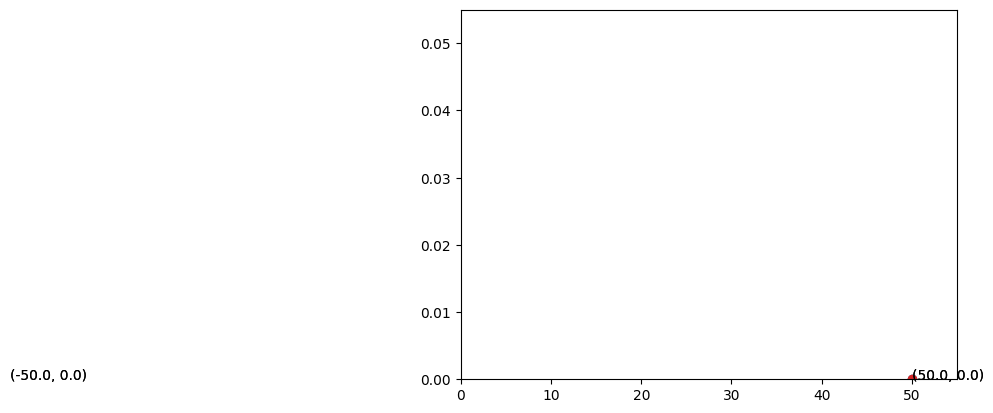

In [11]:
v = np.array([1, 1]) / 2
Sigma = np.array([[1, 1], [1, 1]])

LAMBDA = 100

W_1 = np.array([
    [1, 0], 
    [0, 1]])
bias_1 = np.array([-1, -1])
B_1 = np.array([bias_1, bias_1])

W_2 = np.array([
    [LAMBDA, 0], 
    [LAMBDA, 0]]
)
bias_2 = np.array([-LAMBDA/2, 0])
B_2 = np.array([bias_2, bias_2])


vecs = []
for pair, X in zip(INPUTS, XOR_INPUTS):
    print(X)
    print(Sigma @ X)
    print(Sigma @ X @ W_1)
    print(Sigma @ X @ W_1 + B_1)
    print()
    attn_output = Sigma @ X
    layer_1 = ReLU(attn_output @ W_1 + B_1)
    layer_2 = layer_1 @ W_2 + B_2
    z = v.T @ layer_2
    vecs.append(z)
    # print(z)


    # # compute alpha, beta
    # xsos = np.array([1, 1])
    # UQ = np.ones((2, 2))
    # UK = np.zeros((2, 2))
    # print("---")
    # print(xsos @ UQ @ UK.T @ layer_2.T)

    # print("\n\n")


fig, ax = plt.subplots()
for (i, j) in vecs:
    print(i, j)
    ax.scatter(i, j)
    ax.text(i, j, f"({i}, {j})")
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])


In [2]:
import time

t0 = time.time()
x = 0
for i in range(int(1e8)):
    x += 1

print(time.time() - t0)

8.508508920669556


In [6]:
import numpy as np
arr = np.arange(5)
arr[(4, 3),]

array([4, 3])